# An Introduction to Constant Portfolio Proportion Insurance Strategies (CPPI)

## CPPI

* The CPPI procedure allows for the construction of convex payoffs
* The procedure dynamically allocates total assets to a risky asset and a safe asset

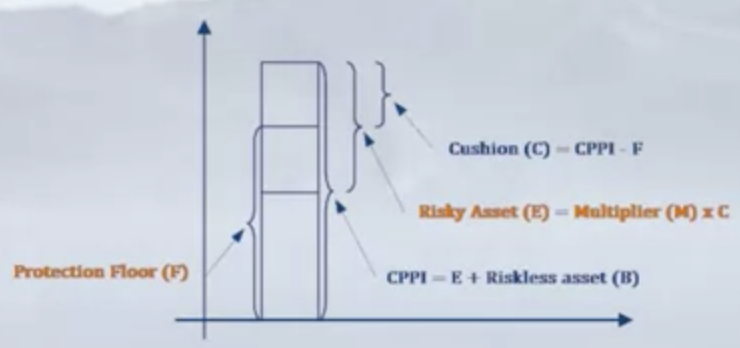

## Downside Protection

If you are not trading frequently there is a gap risk. Or a risk that you go below your protection floor between two trading dates.

* Gap risk materializes if and only if the loss on the risky portfolio relative to the safe portfolio exceeds 1/M within the trading interval.

* CPPI strategies can be used to ensure downside protection through dynamic llocation to a risky and a safe asset

## Extentions to CPPI

1. By introducing max DD constraints
   * The max DD floor keeps on increasing with the increase of returns on your portfolio... until the strategy loses ground, then the max DD floor stays constant until eventually the strategy increases again.
   * max DD is a never decreasing process, it either increases or remains flat
   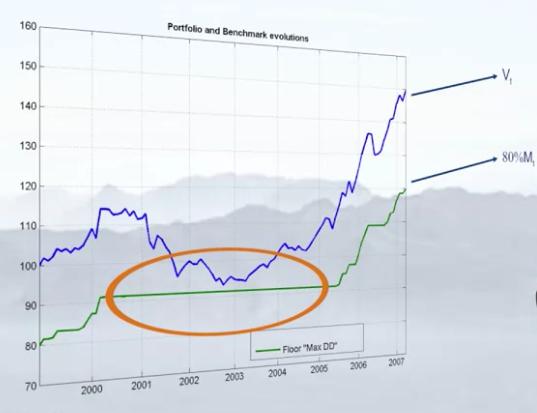

 2. by introducing a cap
     * Protecting downside has an opportunity cost
     * truncate the asset return distribution by giving up on the downside as we always do when we do portfolio insurance, but also on giving up on the upside.
     *  define a threshold level T of t, where
     
     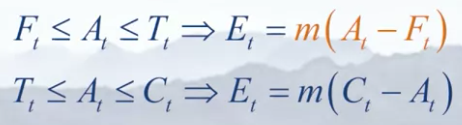

   * By imposing the "smooth-pasting" condition:
       A = T => E = m(T - F) = m(C - T)   
   
   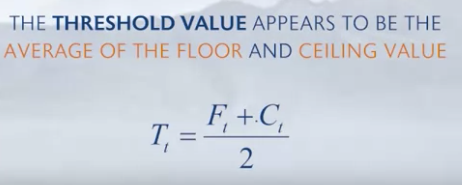

## Lab Session - Implementing Portfolio Insurance (CPPI) and Drawdown Constraints



In [11]:
%load_ext autoreload
%autoreload 2
import edhec_risk_kit as erk
import pandas as pd
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load the industry returns and the total market index we previously created
ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()

The CPPI algorithm is surprisingly simple to implement. This takes as input, the returns of a risky asset and a safe asset, along with the initial wealth to invest at the start, along with a floor that should not be violated.

In [6]:
# Risky assets:
risky_r = ind_return["2000":][["Steel", "Fin", "Beer"]]
risky_r.shape

(228, 3)

We use `.reindex_like(risky_r)` to ensure that the new dataframe has the same shape as the risky_r asset.

In [32]:
# Assume the safe asset is paying 3% per year
safe_r = pd.DataFrame().reindex_like(risky_r)
safe_r.values[:] = 0.03/12 # fast way to set all values to a number
start = 1000 # start at $1000
floor = 0.80 # set the floor to 80 percent of the starting value

Now, we need to backtest this strategy by starting at the beginning and at every point in time:

1. Compute the cushion (asset value minus floor)
2. Compute the allocation (based on the multiplier: m x risk-budget)
3. Compute the new asset value based on returns

Although we rarely use for-loops in working with time-series, relying instead of Pandas and Numpy to do the looping internally (and efficiently) this is easier to do with a traditional for-loop.

### An Aside on Efficiency

Although For-Loops are common, we've almost never used them so far. That is not an accident. For-Loops in python are expensive, and we have so far relied on numpy to do the looping for us efficiently in C. The problem is that it's easy to miss the fact that there is a loop here.

For instance, consider two implementations of the function to compound returns.

In [33]:
def compound1(r):
    return (1+r).prod()-1

# (1+r) is a loop.
# We can not avoid a loop, what we can is push the loop 
# to the most possible efficient implementation 
def compound2(r):
    # np.log(1+r) -> np.log1p(r)
    # and np.exp() -> np.expm1
    return np.expm1(np.log1p(r).sum())

In [34]:
compound1(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [35]:
compound2(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [36]:
%timeit compound1(risky_r)

591 µs ± 34.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [37]:
%timeit compound2(risky_r)

628 µs ± 63 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Astonishingly, on my computer, `compound1` took around 0.8 millisecond, while `compound2` took more than 8 ms per loop, which is an entire order of magnitude! Let's add this to our toolkit, which we'll use later:

```python
def compound(r):
    """
    returns the result of compounding the set of returns in r
    """
    return np.expm1(np.log1p(r).sum())
```

And now, back to CPPI ...

At every step do:
1. Compute the cushion (asset value minus floor)
2. Compute the allocation (based on the multiplier: m x risk-budget)
3. Compute the new asset value based on returns

In [40]:
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start*floor
m = 3
account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)

for step in range(n_steps):
    # 1. compute the risk budget as a ratio:
    cushion = (account_value - floor_value)/account_value
    # How much money do I allocate to the risky asset
    # risky weight:
    risky_w = m * cushion
    # Insert a constraint: to avoid laveraging: risky weight no more than 100%
    risky_w = np.minimum(risky_w, 1)
    # Don't go short: don't go below 0%
    risky_w = np.maximum(risky_w, 0)
    # safe asset weight
    safe_w = 1 - risky_w
    # My risky allocation:
    risky_alloc = account_value * risky_w
    # My safe allocation:
    safe_alloc = account_value * safe_w
    ## update the account value for this time step
    account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
    # save the values so I can look at the history and plot it etc
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value
    account_history.head()

In [42]:
account_history.head()

,Steel,Fin,Beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489


In [44]:
risky_wealth = start*(1+risky_r).cumprod()

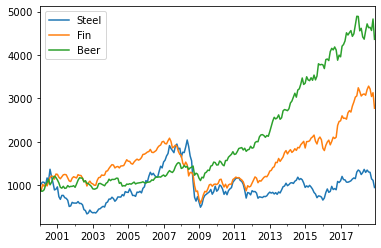

In [45]:
# This is what I get without the CPPI strategy
risky_wealth.plot();

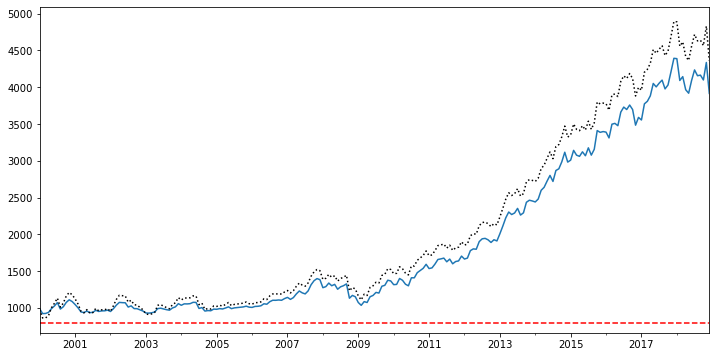

In [47]:
ax = account_history["Beer"].plot(figsize=(12,6))
risky_wealth["Beer"].plot(ax=ax, style="k:")
# Let's draw the floor value
ax.axhline(y=floor_value, color='r', linestyle="--");

<AxesSubplot:>

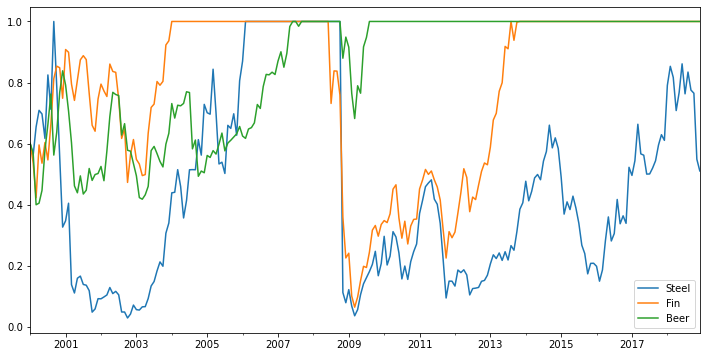

In [49]:
# Let's plot the risky asset allocation history
risky_w_history.plot(figsize=(12,6))

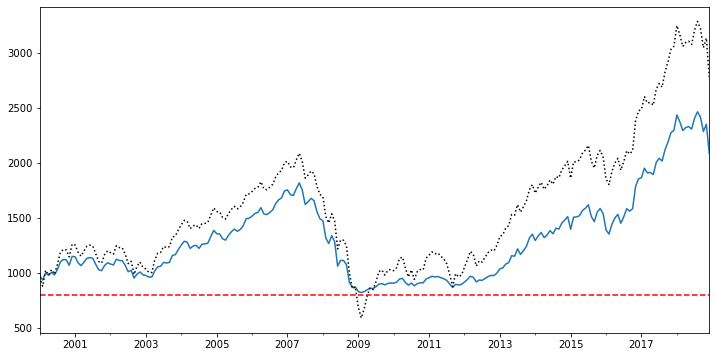

In [50]:
ind = 'Fin'
ax = account_history[ind].plot(figsize=(12, 6))
risky_wealth[ind].plot(ax=ax, style='k:')
ax.axhline(y=floor_value, color='r', linestyle='--')

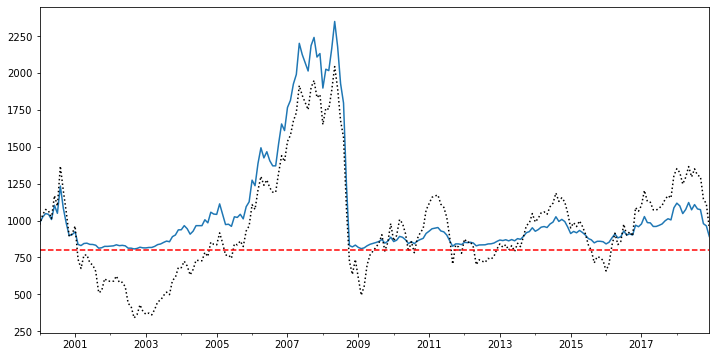

In [51]:
ind = 'Steel'
ax = account_history[ind].plot(figsize=(12, 6))
risky_wealth[ind].plot(ax=ax, style='k:')
ax.axhline(y=floor_value, color='r', linestyle='--')

The volatility and market crash of the steel industry is even more dramatic. You can see that the CPPI strategy (blue) is really bailing you out and for most of the life of that thing, CPPI is by far the place you want to be. It's far less volatile and it protects you from breaching your floor.

In [53]:
erk.summary_stats(risky_r)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.002790,0.312368,-0.326334,4.144381,0.150139,0.208117,-0.102567,-0.758017
Fin,0.055166,0.192909,-0.533218,4.995534,0.091224,0.132175,0.126718,-0.718465
Beer,0.080598,0.138925,-0.493545,4.173881,0.063015,0.091442,0.354314,-0.271368


<AxesSubplot:>

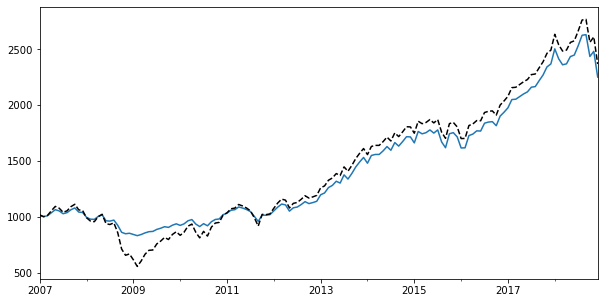

In [58]:
# For more info about the implementation watch the lab session again.
# Here we are going to use run_cppi method from erk
btr = erk.run_cppi(tmi_return["2007":])
ax = btr["Wealth"].plot(legend=False, figsize=(10, 5))
btr["Risky Wealth"].plot(ax = ax, style="k--", legend=False);

In [59]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.069416,0.100381,-0.588292,3.740932,0.045678,0.062953,0.382052,-0.229683


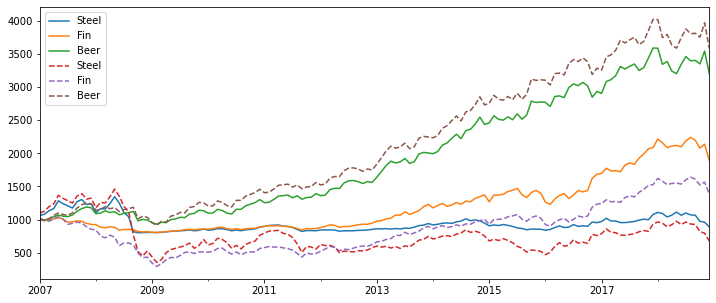

In [60]:
btr = erk.run_cppi(ind_return["2007":][["Steel", "Fin", "Beer"]])
ax = btr["Wealth"].plot(figsize=(12,5))
btr["Risky Wealth"].plot(ax=ax, style="--");

In [61]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.014490,0.126906,-1.554266,11.668243,0.068652,0.098467,-0.341351,-0.404132
Fin,0.054690,0.109579,-0.254976,5.589082,0.047503,0.068951,0.219159,-0.216868
Beer,0.101518,0.114363,-0.743585,4.527865,0.051074,0.069081,0.608531,-0.217280


In [62]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368


<AxesSubplot:>

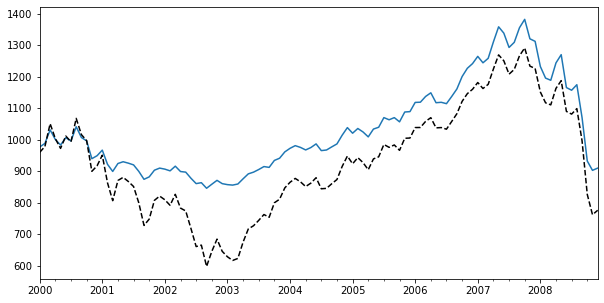

In [63]:
btr = erk.run_cppi(tmi_return["2000":"2008"])
ax = btr["Wealth"].plot(legend=False, figsize=(10, 5))
btr["Risky Wealth"].plot(ax = ax, style="k--", legend=False)

Insurance strategies usually help with drawdowns, but they can also be adapted to explictly limit the drawdown.

## Explicitly Limiting Drawdowns

Modify the code to adjust the floor if needed, based on an additional new parameter drawdown.

```python
if drawdown is not None:
    peak = np.maximum(peak, account_value)
    floor_value = peak*(1-drawdown)
```
You can now call run_cppi witk a parameter drawdown. For instance, to run CPPI and limit the drawdown to 25%

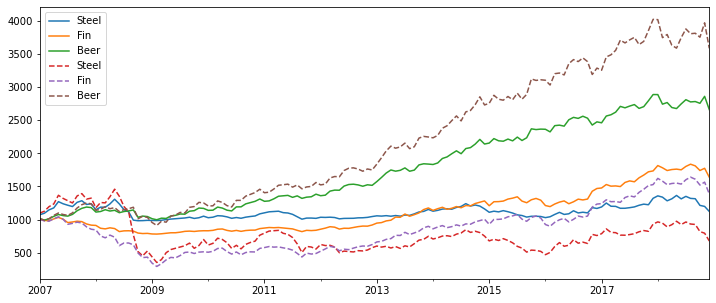

In [65]:
btr = erk.run_cppi(ind_return["2007":][["Steel", "Fin", "Beer"]], drawdown=0.25)
ax = btr["Wealth"].plot(figsize=(12,5))
btr["Risky Wealth"].plot(ax=ax, style="--");

In [67]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368


In [66]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())[["Annualized Return", 
                                                        "Annualized Vol", 
                                                        "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.262958,-0.248059
Fin,0.041975,0.085028,0.136964,-0.243626
Beer,0.084375,0.086263,0.613413,-0.161186
